<a href="https://colab.research.google.com/github/zrruziev/deep_learning_practice/blob/main/TENSORFLOW/TF_Input_Pipeline_benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmarking `Tensorflow_Input_Pipeline` modules:

- `tf.keras.preprocessing.image.ImageDataGenerator`


- `tf.keras.preprocessing.image_dataset_from_directory`


- `tf.data.Dataset`

In [ ]:
import os
import time
from glob import glob
import random

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%load_ext tensorboard

2022-12-19 16:36:18.387901: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# ####### LIMIT GPU USAGE TO 1024MB #######

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#     try:
#         tf.config.set_logical_device_configuration(
#             gpus[0],
#             [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)

In [ ]:
!python --version
print(f"Tensorflow {tf.__version__}")

Python 3.9.15
Tensorflow 2.9.0


### [Dataset Info](https://www.kaggle.com/datasets/wadhasnalhamdan/date-fruit-image-dataset-in-controlled-environment) | Download the dataset from [here...](https://www.kaggle.com/datasets/wadhasnalhamdan/date-fruit-image-dataset-in-controlled-environment/download?datasetVersionNumber=1)



### Define a dataset path

In [ ]:
dataset_path = 'date_fruit/'


BATCH_SIZE = 32
IMG_SIZE = 224

### Prepare `imgDataGen` object by utilizing `ImageDataGenerator` module

In [ ]:
imgDataGen = tf.keras.preprocessing.image.ImageDataGenerator()

imgDataGen = imgDataGen.flow_from_directory(dataset_path,
                                              target_size=(IMG_SIZE,IMG_SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode="sparse",
                                              color_mode="rgb",
                                              shuffle=True,
                                              interpolation='nearest')

Found 1658 images belonging to 9 classes.


['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


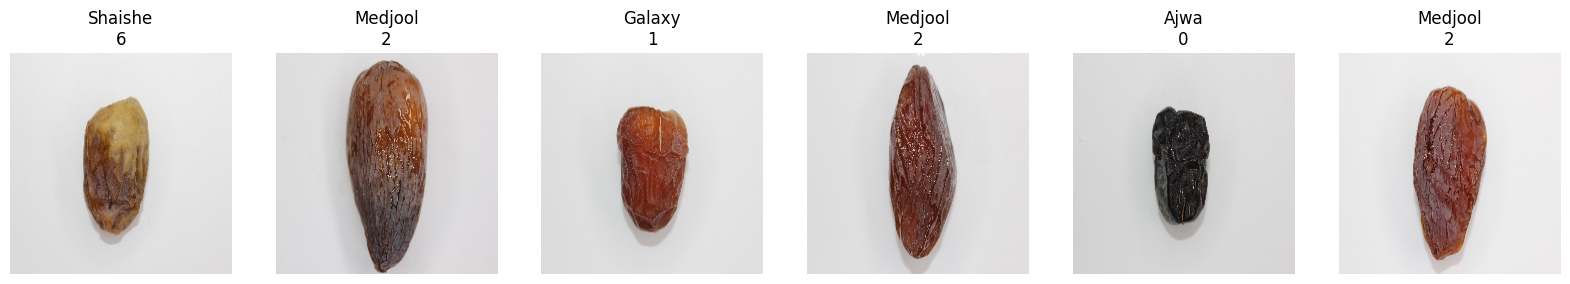

In [ ]:
# Show classes
imgDataGen_classes = list(imgDataGen.class_indices.keys())
print(imgDataGen_classes)

for images, labels in imgDataGen:
    plt.figure(figsize=(20, 5))
    for i in range(6):
        ax = plt.subplot(1, 6, i + 1)
        plt.imshow(images[i].astype('uint8'))
        label = int(labels[i])
        plt.title(f"{imgDataGen_classes[label]}\n{label}")
        plt.axis("off")
    break

***

### Prepare `imgDataFromDir` object by utilizing `image_dataset_from_directory` module

In [ ]:
imgDataFromDir = tf.keras.preprocessing.image_dataset_from_directory(dataset_path,
                                                                      labels="inferred",
                                                                      label_mode="int",
                                                                      color_mode="rgb",
                                                                      batch_size=BATCH_SIZE,
                                                                      image_size=(IMG_SIZE, IMG_SIZE),
                                                                      interpolation='nearest',
                                                                      shuffle=True)

class_names = imgDataFromDir.class_names

imgDataFromDir = imgDataFromDir.cache()
imgDataFromDir = imgDataFromDir.prefetch(tf.data.AUTOTUNE)
type(imgDataFromDir)

Found 1658 files belonging to 9 classes.


2022-12-19 16:36:21.523427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 16:36:21.902014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10093 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


tensorflow.python.data.ops.dataset_ops.PrefetchDataset

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


2022-12-19 16:36:23.649463: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


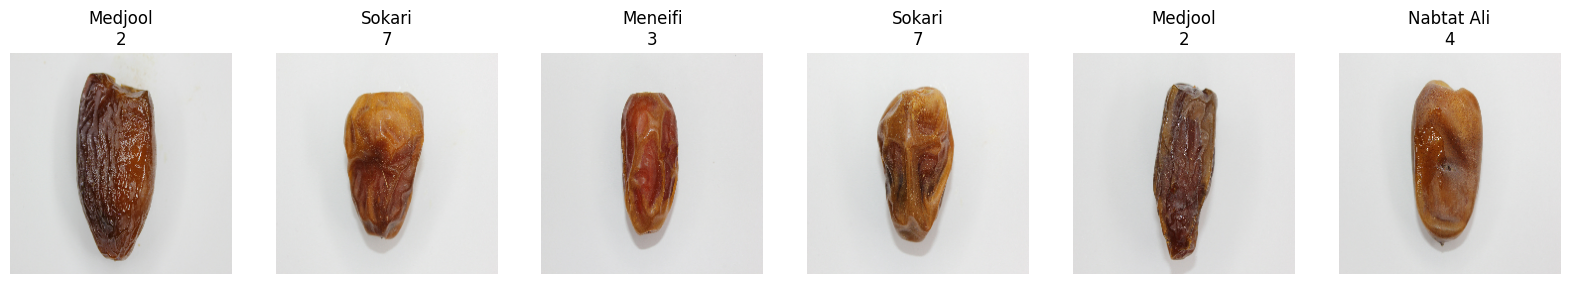

In [ ]:
print(class_names)

# Show some data-samples with their classnames and corresponding one-hot encoded labels
for images, labels in imgDataFromDir:
    plt.figure(figsize=(20, 5))
    for i in range(6):
        ax = plt.subplot(1, 6, i + 1)
        label = int(labels[i])
        plt.title(f"{class_names[label]}\n{label}")
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis("off")
    break

***

### Prepare `tf_data` object by utilizing `tf.data.Dataset` api

In [ ]:
subdirs = []
for subdir in sorted(tf.io.gfile.listdir(dataset_path)):
    if tf.io.gfile.isdir(tf.io.gfile.join(dataset_path, subdir)):
        if subdir.endswith("/"):
            subdir = subdir[:-1]
        subdirs.append(subdir)

class_names = subdirs

def parse_image_and_label(filename):
    parts = tf.strings.split(filename, os.sep)
    boolean_label = parts[-2] == class_names
    label = tf.argmax(boolean_label)  # for SparseCategoricalCrossentropy()
#     label = tf.one_hot(label, len(class_names))  # for CategoricalCrossentropy()

    image = tf.io.read_file(filename)
    image = tf.io.decode_image(image, channels=3)
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    # image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    
    return image, label


tf_data = tf.data.Dataset.list_files(f"{dataset_path}*/*/")
tf_data = tf_data.map(parse_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
tf_data = tf_data.shuffle(BATCH_SIZE*8)
tf_data = tf_data.cache()
tf_data = tf_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
tf_data = tf_data.prefetch(tf.data.AUTOTUNE)

<details>
  <summary><font size="4" color="darkgreen"><b>Click to see another way for tf.data.Dataset with `from_tensor_slices` method preparation</b></font></summary>

- Here `tf.data.Dataset.from_tensor_slices` is used instead of `tf.data.Dataset.list_files`    
    
```python
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(1024)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


class_names = sorted(os.listdir(dataset_path))
filenames = glob(dataset_path + '/*/*')
random.shuffle(filenames)
labels = [class_names.index(name.split('/')[-2]) for name in filenames]
# print(class_names)
# for img, label in zip(filenames, labels):
#     print(label, img)


filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
tf_data = configure_for_performance(ds)
```
    
    

</details>

    


['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


2022-12-19 16:36:26.357447: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


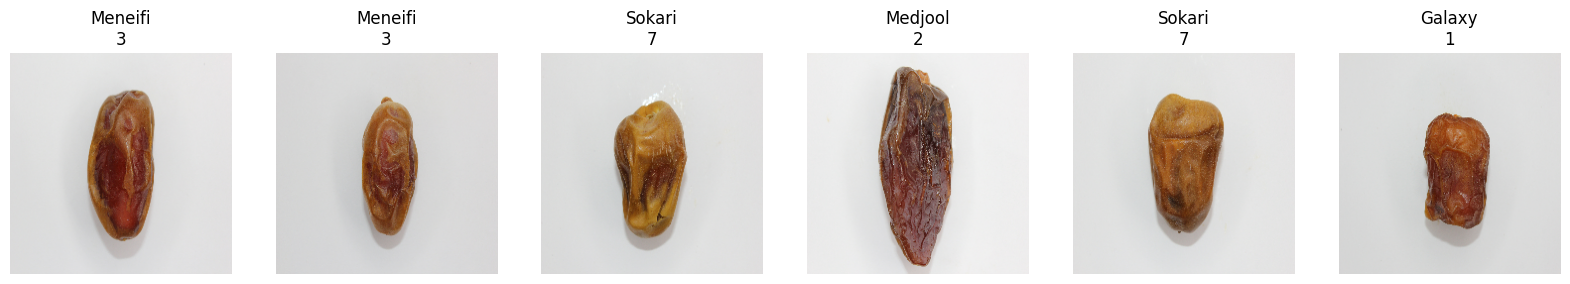

In [ ]:
print(class_names)
# Show some data-samples with their classnames and corresponding one-hot encoded labels
for images, labels in tf_data:
    plt.figure(figsize=(20, 5))
    for i in range(6):
        ax = plt.subplot(1, 6, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f"{class_names[labels[i]]}\n{labels[i].numpy()}")
        plt.axis("off")
    break

***

## Build a model

In [ ]:
def build_model():
    
    model = tf.keras.Sequential([
                
                tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3)),
        
                tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                tf.keras.layers.MaxPooling2D(2,2),

                tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                tf.keras.layers.MaxPooling2D(2,2),        

                tf.keras.layers.GlobalAvgPool2D(),

                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(len(class_names), activation='softmax')
                ])


    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                        

### Prepare training function

In [ ]:
def train_the_model(data_gen, epochs=6, profiler=False):
    
    tf.keras.backend.clear_session()
    
    model = build_model()

    if profiler:
        # Prepare tensorboard with profiler
        tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f'tboard/{profiler}',
                                                     histogram_freq=1,
                                                     profile_batch = (160,200)) # between 160:200 batches
        
        # Start training
        model.fit(data_gen, epochs=epochs, callbacks=[tensorboard])
    else:
        # Start training
        model.fit(data_gen, epochs=epochs)

### Training with `imgDataGen`

In [ ]:
# train_the_model(imgDataGen)
train_the_model(imgDataGen, profiler='ImageDataGenerator')

2022-12-19 16:36:26.698558: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-12-19 16:36:26.698581: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-12-19 16:36:26.698599: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-12-19 16:36:26.698830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda-11.4/targets/x86_64-linux/lib
2022-12-19 16:36:26.815040: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-12-19 16:36:26.815148: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


Epoch 1/6


2022-12-19 16:36:29.855663: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


52/52 [==============================] - 59s 1s/step - loss: 8.2616 - accuracy: 0.1701
Epoch 2/6
52/52 [==============================] - 62s 1s/step - loss: 1.7136 - accuracy: 0.3540
Epoch 3/6
52/52 [==============================] - 58s 1s/step - loss: 1.3645 - accuracy: 0.4958
Epoch 4/6
 3/52 [>.............................] - ETA: 54s - loss: 1.2351 - accuracy: 0.5417

2022-12-19 16:39:30.739203: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-12-19 16:39:30.739224: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


43/52 [=======================>......] - ETA: 9s - loss: 1.1587 - accuracy: 0.5584 

2022-12-19 16:40:14.661693: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-19 16:40:14.662094: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-12-19 16:40:14.722159: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 4753 callback api events and 4676 activity events. 
2022-12-19 16:40:14.765070: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-12-19 16:40:14.805544: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tboard/ImageDataGenerator/plugins/profile/2022_12_19_16_40_14

2022-12-19 16:40:14.857893: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tboard/ImageDataGenerator/plugins/profile/2022_12_19_16_40_14/hp.trace.json.gz


44/52 [========================>.....] - ETA: 8s - loss: 1.1670 - accuracy: 0.5606

2022-12-19 16:40:14.919711: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tboard/ImageDataGenerator/plugins/profile/2022_12_19_16_40_14

2022-12-19 16:40:14.925719: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to tboard/ImageDataGenerator/plugins/profile/2022_12_19_16_40_14/hp.memory_profile.json.gz
2022-12-19 16:40:14.926813: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: tboard/ImageDataGenerator/plugins/profile/2022_12_19_16_40_14
Dumped tool data for xplane.pb to tboard/ImageDataGenerator/plugins/profile/2022_12_19_16_40_14/hp.xplane.pb
Dumped tool data for overview_page.pb to tboard/ImageDataGenerator/plugins/profile/2022_12_19_16_40_14/hp.overview_page.pb
Dumped tool data for input_pipeline.pb to tboard/ImageDataGenerator/plugins/profile/2022_12_19_16_40_14/hp.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to tboard/ImageDataGenerator/p

52/52 [==============================] - 56s 1s/step - loss: 1.1650 - accuracy: 0.5609
Epoch 5/6
52/52 [==============================] - 56s 1s/step - loss: 0.9996 - accuracy: 0.6327
Epoch 6/6
52/52 [==============================] - 56s 1s/step - loss: 0.9126 - accuracy: 0.6562


### Training with `imgDataFromDir`

In [ ]:
# train_the_model(imgDataFromDir)
train_the_model(imgDataFromDir, profiler='imgDataFromDir')

Epoch 1/6


2022-12-19 16:42:14.741200: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-12-19 16:42:14.741222: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-12-19 16:42:14.850885: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-12-19 16:42:14.851009: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


52/52 [==============================] - 8s 128ms/step - loss: 8.2034 - accuracy: 0.1713
Epoch 2/6
52/52 [==============================] - 3s 62ms/step - loss: 1.6887 - accuracy: 0.3752
Epoch 3/6
52/52 [==============================] - 3s 62ms/step - loss: 1.3010 - accuracy: 0.5199
Epoch 4/6
 4/52 [=>............................] - ETA: 5s - loss: 1.3533 - accuracy: 0.5391

2022-12-19 16:42:29.737743: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-12-19 16:42:29.737761: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


43/52 [=======================>......] - ETA: 0s - loss: 1.1212 - accuracy: 0.5959

2022-12-19 16:42:32.420481: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-19 16:42:32.420815: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-12-19 16:42:32.474137: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 4876 callback api events and 4799 activity events. 
2022-12-19 16:42:32.513303: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-12-19 16:42:32.553814: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tboard/imgDataFromDir/plugins/profile/2022_12_19_16_42_32

2022-12-19 16:42:32.604747: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tboard/imgDataFromDir/plugins/profile/2022_12_19_16_42_32/hp.trace.json.gz


46/52 [=========================>....] - ETA: 0s - loss: 1.1151 - accuracy: 0.5931

2022-12-19 16:42:32.661502: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tboard/imgDataFromDir/plugins/profile/2022_12_19_16_42_32

2022-12-19 16:42:32.666985: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to tboard/imgDataFromDir/plugins/profile/2022_12_19_16_42_32/hp.memory_profile.json.gz
2022-12-19 16:42:32.668057: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: tboard/imgDataFromDir/plugins/profile/2022_12_19_16_42_32
Dumped tool data for xplane.pb to tboard/imgDataFromDir/plugins/profile/2022_12_19_16_42_32/hp.xplane.pb
Dumped tool data for overview_page.pb to tboard/imgDataFromDir/plugins/profile/2022_12_19_16_42_32/hp.overview_page.pb
Dumped tool data for input_pipeline.pb to tboard/imgDataFromDir/plugins/profile/2022_12_19_16_42_32/hp.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to tboard/imgDataFromDir/plugins/profile/2022_12_19_16

52/52 [==============================] - 4s 70ms/step - loss: 1.0913 - accuracy: 0.5983
Epoch 5/6
52/52 [==============================] - 3s 64ms/step - loss: 0.9589 - accuracy: 0.6550
Epoch 6/6
52/52 [==============================] - 3s 64ms/step - loss: 0.8209 - accuracy: 0.7021


### Train with `tf_data`

In [ ]:
# train_the_model(tf_data)
train_the_model(tf_data, profiler='tf_data')

Epoch 1/6


2022-12-19 16:42:39.857248: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-12-19 16:42:39.857272: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-12-19 16:42:39.968352: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-12-19 16:42:39.968444: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


52/52 [==============================] - 8s 133ms/step - loss: 7.2134 - accuracy: 0.1568
Epoch 2/6
52/52 [==============================] - 4s 68ms/step - loss: 1.8330 - accuracy: 0.3353
Epoch 3/6
52/52 [==============================] - 4s 68ms/step - loss: 1.4690 - accuracy: 0.4421
Epoch 4/6
 4/52 [=>............................] - ETA: 5s - loss: 1.4801 - accuracy: 0.4531

2022-12-19 16:42:55.725661: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-12-19 16:42:55.725682: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


43/52 [=======================>......] - ETA: 0s - loss: 1.2169 - accuracy: 0.5291

2022-12-19 16:42:58.615889: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-19 16:42:58.616301: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-12-19 16:42:58.674191: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 4753 callback api events and 4674 activity events. 
2022-12-19 16:42:58.714883: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-12-19 16:42:58.758893: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tboard/tf_data/plugins/profile/2022_12_19_16_42_58

2022-12-19 16:42:58.814209: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tboard/tf_data/plugins/profile/2022_12_19_16_42_58/hp.trace.json.gz


46/52 [=========================>....] - ETA: 0s - loss: 1.2220 - accuracy: 0.5272

2022-12-19 16:42:58.878431: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tboard/tf_data/plugins/profile/2022_12_19_16_42_58

2022-12-19 16:42:58.883704: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to tboard/tf_data/plugins/profile/2022_12_19_16_42_58/hp.memory_profile.json.gz
2022-12-19 16:42:58.884941: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: tboard/tf_data/plugins/profile/2022_12_19_16_42_58
Dumped tool data for xplane.pb to tboard/tf_data/plugins/profile/2022_12_19_16_42_58/hp.xplane.pb
Dumped tool data for overview_page.pb to tboard/tf_data/plugins/profile/2022_12_19_16_42_58/hp.overview_page.pb
Dumped tool data for input_pipeline.pb to tboard/tf_data/plugins/profile/2022_12_19_16_42_58/hp.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to tboard/tf_data/plugins/profile/2022_12_19_16_42_58/hp.tensorflow_stats.pb
Dumped tool data fo

52/52 [==============================] - 4s 75ms/step - loss: 1.2163 - accuracy: 0.5344
Epoch 5/6
52/52 [==============================] - 3s 66ms/step - loss: 1.0947 - accuracy: 0.5893
Epoch 6/6
52/52 [==============================] - 3s 67ms/step - loss: 0.9589 - accuracy: 0.6297


***

### Show Tensorboard if you trained the model with `profiler`

In [ ]:
# !pip install tensorboard-plugin-profile
# !export LD_LIBRARY_PATH=/usr/local/cuda/extras/CUPTI/lib64:$LD_LIBRARY_PATH

# !export LD_LIBRARY_PATH=/usr/local/cuda-11.4/targets/x86_64-linux/lib

In [ ]:
%tensorboard --logdir tboard/

***

## The above results may differ by hardware specs:

**Experiment hardware specs:**
- CPU: i5-11600K, 3.90GHz, 6cores(12threads)
- GPU: NVIDIA GeForce RTX 2060 12GB
- OS : Ubuntu 22.04.1 LTS(64-bit)

***